In [1]:
import festim as F
import h_transport_materials as htm
import numpy as np
import meshio

# Gold properties
diffusivity_gold = htm.diffusivities.filter(material="gold")
D_Au = diffusivity_gold[0]

In [2]:

mesh = meshio.read("{}".format("../challenge_D/challenge_mesh.med"))

# In order to use MeshFunction of FEniCS
# The tag must be a positive number (size_t)

# this doesn't work cause cell_data_dict doesn't have a setter
mesh.cell_data_dict["cell_tags"]["triangle"] *= -1
mesh.cell_data_dict["cell_tags"]["line"] *= -1

# print the correspondance
print("This is the correspondance dict")
print(mesh.cell_tags)
# mesh.cell_tags = {-6: ['Down'], -7: ['Top'], -8: ['Lying on Top']}

# Export mesh that contains only triangular faces
# along with tags
domains_file = meshio.write_points_cells(
    "../challenge_D/mesh_domains.xdmf",
    mesh.points,
    [mesh.cells[1]],
    cell_data={"f": [-1 * mesh.cell_data["cell_tags"][1]]},
)

# Export mesh that contains only lines
# along with tags

boundaries_file = meshio.write_points_cells(
    "../challenge_D/mesh_boundaries.xdmf",
    mesh.points,
    [mesh.cells[0]],
    cell_data={"f": [-1 * mesh.cell_data["cell_tags"][0]]},
)


This is the correspondance dict
{-6: ['solid'], -7: ['inner_boundary'], -8: ['outer_boundary']}


In [3]:
# IDs for volumes and surfaces (must be the same as in xdmf files)

id_solid = 6

id_inner_boundary = 7
id_outer_boundary = 8

my_model = F.Simulation(log_level=20)

# define mesh
my_model.mesh = F.MeshFromXDMF(
    volume_file="../challenge_D/mesh_domains.xdmf",
    boundary_file="../challenge_D/mesh_boundaries.xdmf",
)

# define materials
gold = F.Material(
    id=id_solid, D_0=D_Au.pre_exp.magnitude, E_D=D_Au.act_energy.magnitude
)
my_model.materials = F.Materials([gold])

# define temperature
my_model.T = F.Temperature(value=500)

# define boundary conditions
my_model.boundary_conditions = [
    F.DirichletBC(surfaces=id_inner_boundary, value=1e18, field="solute"),
    F.DirichletBC(
        surfaces=id_outer_boundary, value=0, field="solute"
    ),
]

# define exports
my_model.exports = F.Exports([F.XDMFExport("solute", folder="../challenge_D/", mode=1)])

my_model.settings = F.Settings(
    transient=False,
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
)

my_model.initialise()
my_model.run()

Succesfully load mesh with 17641 cells
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may ta

Text(0.5, 1.0, 'Mobile tritium concentration (H/m3)')

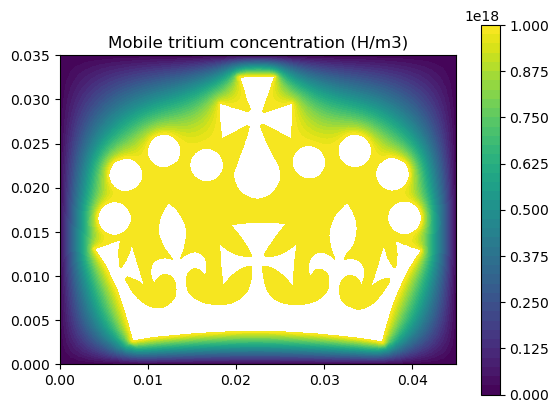

In [9]:
import fenics as f
import matplotlib.pyplot as plt
sol = my_model.h_transport_problem.mobile.mobile_concentration()
CS = f.plot(sol)

plt.colorbar(CS)
plt.title("Mobile tritium concentration (H/m3)")